# Decision Trees

In [1]:
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import os
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [2]:
od.download('https://www.kaggle.com/jsphyg/weather-dataset-rattle-package')

Skipping, found downloaded files in ".\weather-dataset-rattle-package" (use force=True to force download)


In [3]:
os.listdir('weather-dataset-rattle-package')

['weatherAUS.csv']

In [4]:
raw_df = pd.read_csv('weather-dataset-rattle-package/weatherAUS.csv')

In [5]:
raw_df 

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6          NaN   
1       2008-12-02   Albury      7.4     25.1       0.0          NaN   
2       2008-12-03   Albury     12.9     25.7       0.0          NaN   
3       2008-12-04   Albury      9.2     28.0       0.0          NaN   
4       2008-12-05   Albury     17.5     32.3       1.0          NaN   
...            ...      ...      ...      ...       ...          ...   
145455  2017-06-21    Uluru      2.8     23.4       0.0          NaN   
145456  2017-06-22    Uluru      3.6     25.3       0.0          NaN   
145457  2017-06-23    Uluru      5.4     26.9       0.0          NaN   
145458  2017-06-24    Uluru      7.8     27.0       0.0          NaN   
145459  2017-06-25    Uluru     14.9      NaN       0.0          NaN   

        Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
0            NaN           W           44.0          W        WNW   
1            NaN         WNW           44.0        NNW        WSW   
2            NaN         WSW           46.0          W        WSW   
3            NaN          NE           24.0         SE          E   
4            NaN           W           41.0        ENE         NW   
...          ...         ...            ...        ...        ...   
145455       NaN           E           31.0         SE        ENE   
145456       NaN         NNW           22.0         SE          N   
145457       NaN           N           37.0         SE        WNW   
145458       NaN          SE           28.0        SSE          N   
145459       NaN         NaN            NaN        ESE        ESE   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
0               20.0          24.0         71.0         22.0       1007.7   
1                4.0          22.0         44.0         25.0       1010.6   
2               19.0          26.0         38.0         30.0       1007.6   
3               11.0           9.0         45.0         16.0       1017.6   
4                7.0          20.0         82.0         33.0       1010.8   
...              ...           ...          ...          ...          ...   
145455          13.0          11.0         51.0         24.0       1024.6   
145456          13.0           9.0         56.0         21.0       1023.5   
145457           9.0           9.0         53.0         24.0       1021.0   
145458          13.0           7.0         51.0         24.0       1019.4   
145459          17.0          17.0         62.0         36.0       1020.2   

        Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm RainToday  \
0            1007.1       8.0       NaN     16.9     21.8        No   
1            1007.8       NaN       NaN     17.2     24.3        No   
2            1008.7       NaN       2.0     21.0     23.2        No   
3            1012.8       NaN       NaN     18.1     26.5        No   
4            1006.0       7.0       8.0     17.8     29.7        No   
...             ...       ...       ...      ...      ...       ...   
145455       1020.3       NaN       NaN     10.1     22.4        No   
145456       1019.1       NaN       NaN     10.9     24.5        No   
145457       1016.8       NaN       NaN     12.5     26.1        No   
145458       1016.5       3.0       2.0     15.1     26.0        No   
145459       1017.9       8.0       8.0     15.0     20.9        No   

       RainTomorrow  
0                No  
1                No  
2                No  
3                No  
4                No  
...             ...  
145455           No  
145456           No  
145457           No  
145458           No  
145459          NaN  

[145460 rows x 23 columns]

In [6]:
raw_df.dropna(subset=['RainTomorrow'], inplace=True)

Preparing the Data for Training

In [7]:
year = pd.to_datetime(raw_df.Date).dt.year

train_df = raw_df[year < 2015]
val_df = raw_df[year == 2015]
test_df = raw_df[year > 2015]

In [8]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (98988, 23)
val_df.shape : (17231, 23)
test_df.shape : (25974, 23)


In [9]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'

In [10]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

In [11]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

Imputing missing numeric values

In [12]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'mean').fit(raw_df[numeric_cols])
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

Scaling Numeric Features

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(raw_df[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

Encoding Categorical Data

In [14]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [15]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

Training and Visualizing Decision Trees

In [16]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, train_targets)

DecisionTreeClassifier(random_state=42)

Evaluation

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix
train_preds = model.predict(X_train)
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [19]:
pd.value_counts(train_preds)

No     76707
Yes    22281
dtype: int64

In [20]:
train_probs = model.predict_proba(X_train)
train_probs

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [21]:
accuracy_score(train_targets, train_preds)

0.9999797955307714

In [22]:
model.score(X_val, val_targets)

0.7921188555510418

Visualization

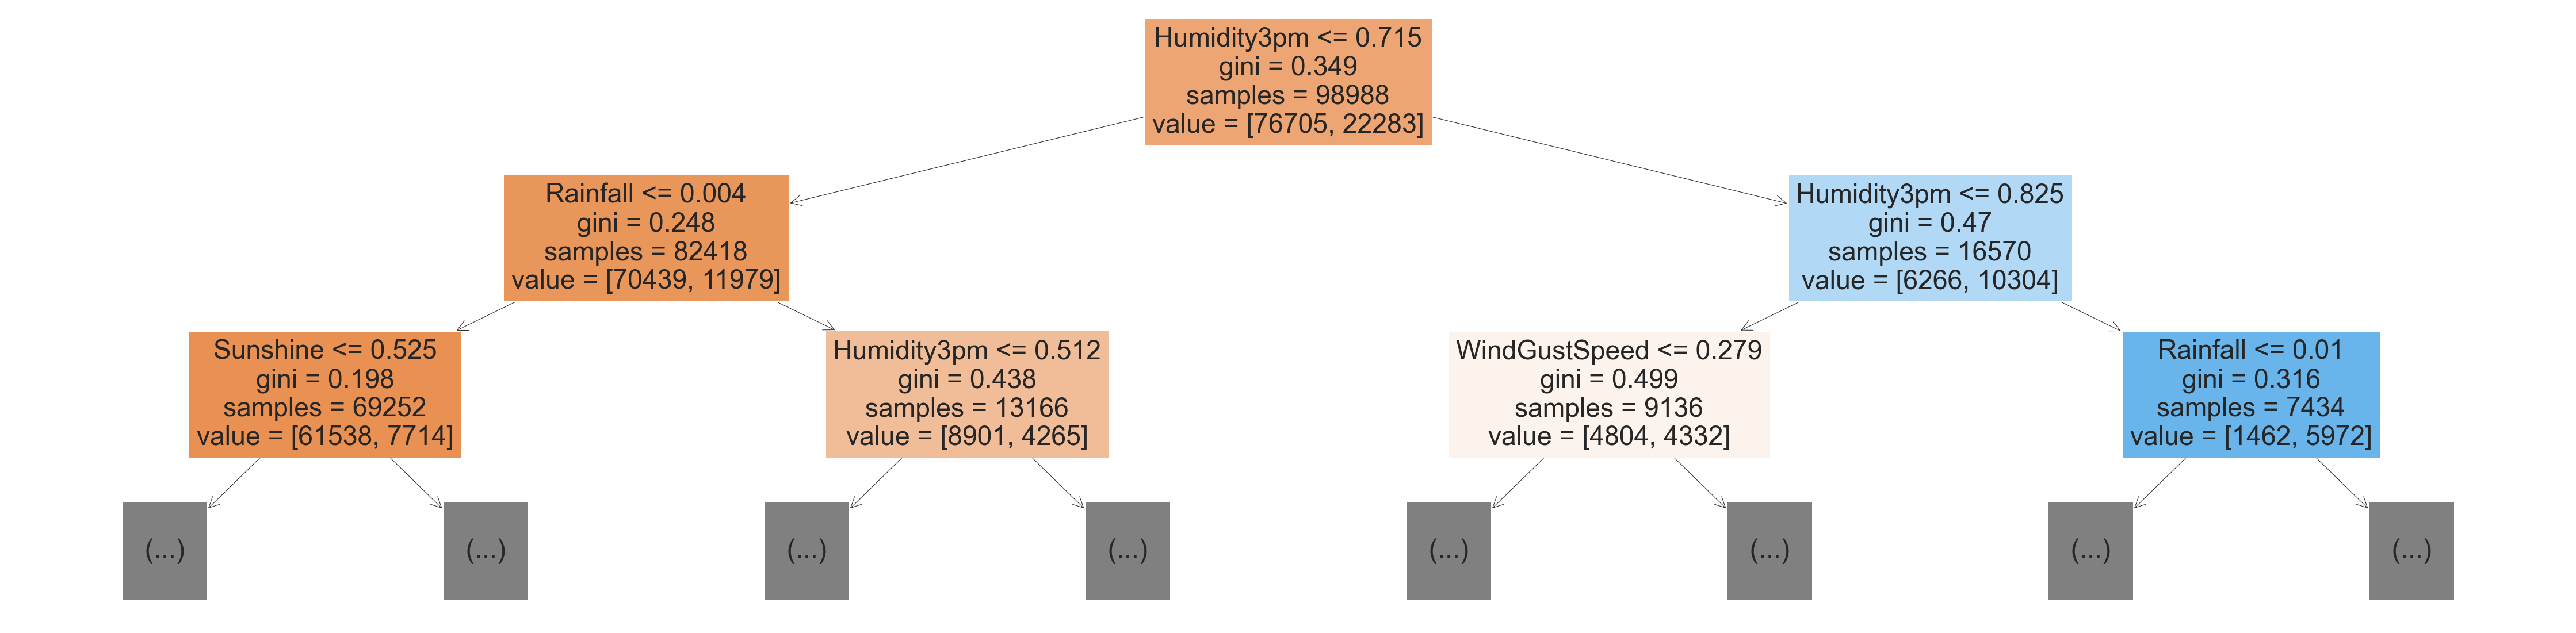

In [24]:
from sklearn.tree import plot_tree, export_text
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, max_depth=2, filled=True);

In [25]:
model.tree_.max_depth

48

In [26]:
tree_text = export_text(model, max_depth=10, feature_names=list(X_train.columns))
print(tree_text[:5000])

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- WindDir9am_NE <= 0.50
|   |   |   |   |   |   |   |--- Location_Watsonia <= 0.50
|   |   |   |   |   |   |   |   |--- Cloud9am <= 0.83
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm <= 0.07
|   |   |   |   |   |   |   |   |   |   |--- Pressure3pm <= 0.46
|   |   |   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |   |   |   |--- Pressure3pm >  0.46
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm >  0.07
|   |   |   |   |   |   |   |   |   |   |--- MinTemp <= 0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- MinTemp >  0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated

Feature Importance

In [27]:
model.feature_importances_

array([3.48942086e-02, 3.23605486e-02, 5.91385668e-02, 2.49619907e-02,
       4.94652143e-02, 5.63334673e-02, 2.80205998e-02, 2.98128801e-02,
       4.02182908e-02, 2.61441297e-01, 3.44145027e-02, 6.20573699e-02,
       1.36406176e-02, 1.69229866e-02, 3.50001550e-02, 3.04064076e-02,
       2.24086587e-03, 2.08018104e-03, 1.27475954e-03, 7.26936324e-04,
       1.39779517e-03, 1.15264873e-03, 6.92808159e-04, 1.80675598e-03,
       1.08370901e-03, 1.19773895e-03, 8.87119103e-04, 2.15764220e-03,
       1.67094731e-03, 7.98919493e-05, 1.10558668e-03, 1.42008656e-03,
       4.10087635e-04, 1.09028115e-03, 1.44164766e-03, 9.08284767e-04,
       1.05770304e-03, 6.18133455e-04, 1.80387272e-03, 2.10403527e-03,
       2.74413333e-04, 7.31599405e-04, 1.35408990e-03, 1.54759332e-03,
       1.30917564e-03, 1.07134670e-03, 8.36408023e-04, 1.62662229e-03,
       1.00326116e-03, 2.16053455e-03, 8.46802258e-04, 1.88919081e-03,
       9.29325203e-04, 1.29545157e-03, 1.27604831e-03, 5.12736888e-04,
      

In [28]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
importance_df.head(10)

feature  importance
9     Humidity3pm    0.261441
11    Pressure3pm    0.062057
2        Rainfall    0.059139
5   WindGustSpeed    0.056333
4        Sunshine    0.049465
8     Humidity9am    0.040218
14        Temp9am    0.035000
0         MinTemp    0.034894
10    Pressure9am    0.034415
1         MaxTemp    0.032361

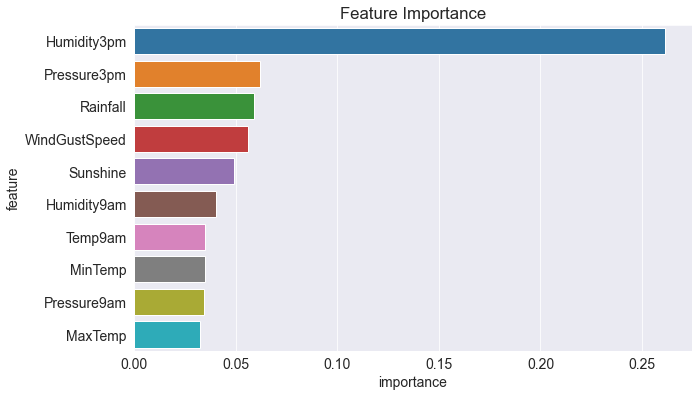

In [29]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

Hyperparameter Tuning and Overfitting

max_depth

In [31]:
model = DecisionTreeClassifier(max_depth=3, random_state=42)
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [32]:
model.score(X_train, train_targets)

0.8291308037337859

In [33]:
model.score(X_val, val_targets)

0.8334397307178921

In [34]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, train_targets)
    train_acc = 1 - model.score(X_train, train_targets)
    val_acc = 1 - model.score(X_val, val_targets)
    return {'Max Depth': md, 'Training Error': train_acc, 'Validation Error': val_acc}

In [35]:
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

In [36]:
errors_df

Max Depth  Training Error  Validation Error
0           1        0.184315          0.177935
1           2        0.179547          0.172712
2           3        0.170869          0.166560
3           4        0.165707          0.164355
4           5        0.160676          0.159074
5           6        0.156271          0.157275
6           7        0.153312          0.154605
7           8        0.147806          0.158029
8           9        0.140906          0.156578
9          10        0.132945          0.157333
10         11        0.123227          0.159248
11         12        0.113489          0.160815
12         13        0.101750          0.163833
13         14        0.089981          0.167373
14         15        0.078999          0.171261
15         16        0.068180          0.174279
16         17        0.058138          0.176890
17         18        0.048733          0.181243
18         19        0.040025          0.187569
19         20        0.032539          0.190297

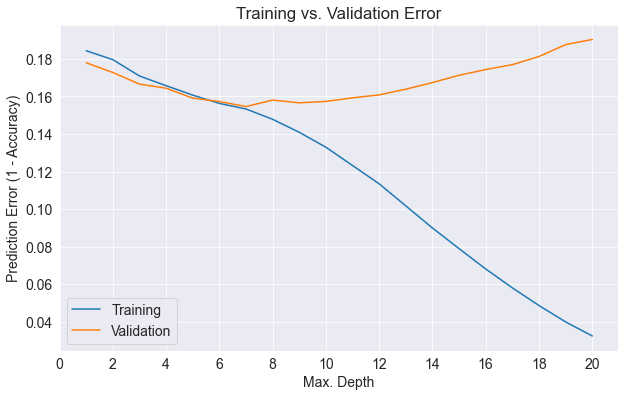

In [37]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

In [38]:
model = DecisionTreeClassifier(max_depth=7, random_state=42).fit(X_train, train_targets)
model.score(X_val, val_targets)

0.8453949277465034

#### Training a Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)

n_jobs allows the random forest to use mutiple parallel workers to train decision trees, and random_state=42 ensures that the we get the same results for each execution.

In [41]:
model.fit(X_train, train_targets)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [42]:
model.score(X_train, train_targets)

0.9999494888269285

In [43]:
model.score(X_val, val_targets)

0.8566537055307295

In [44]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.93, 0.07],
       [1.  , 0.  ],
       [0.99, 0.01],
       ...,
       [0.99, 0.01],
       [1.  , 0.  ],
       [0.96, 0.04]])

In [50]:
len(model.estimators_)

100

In [45]:
model.estimators_[0]

DecisionTreeClassifier(max_features='auto', random_state=1608637542)

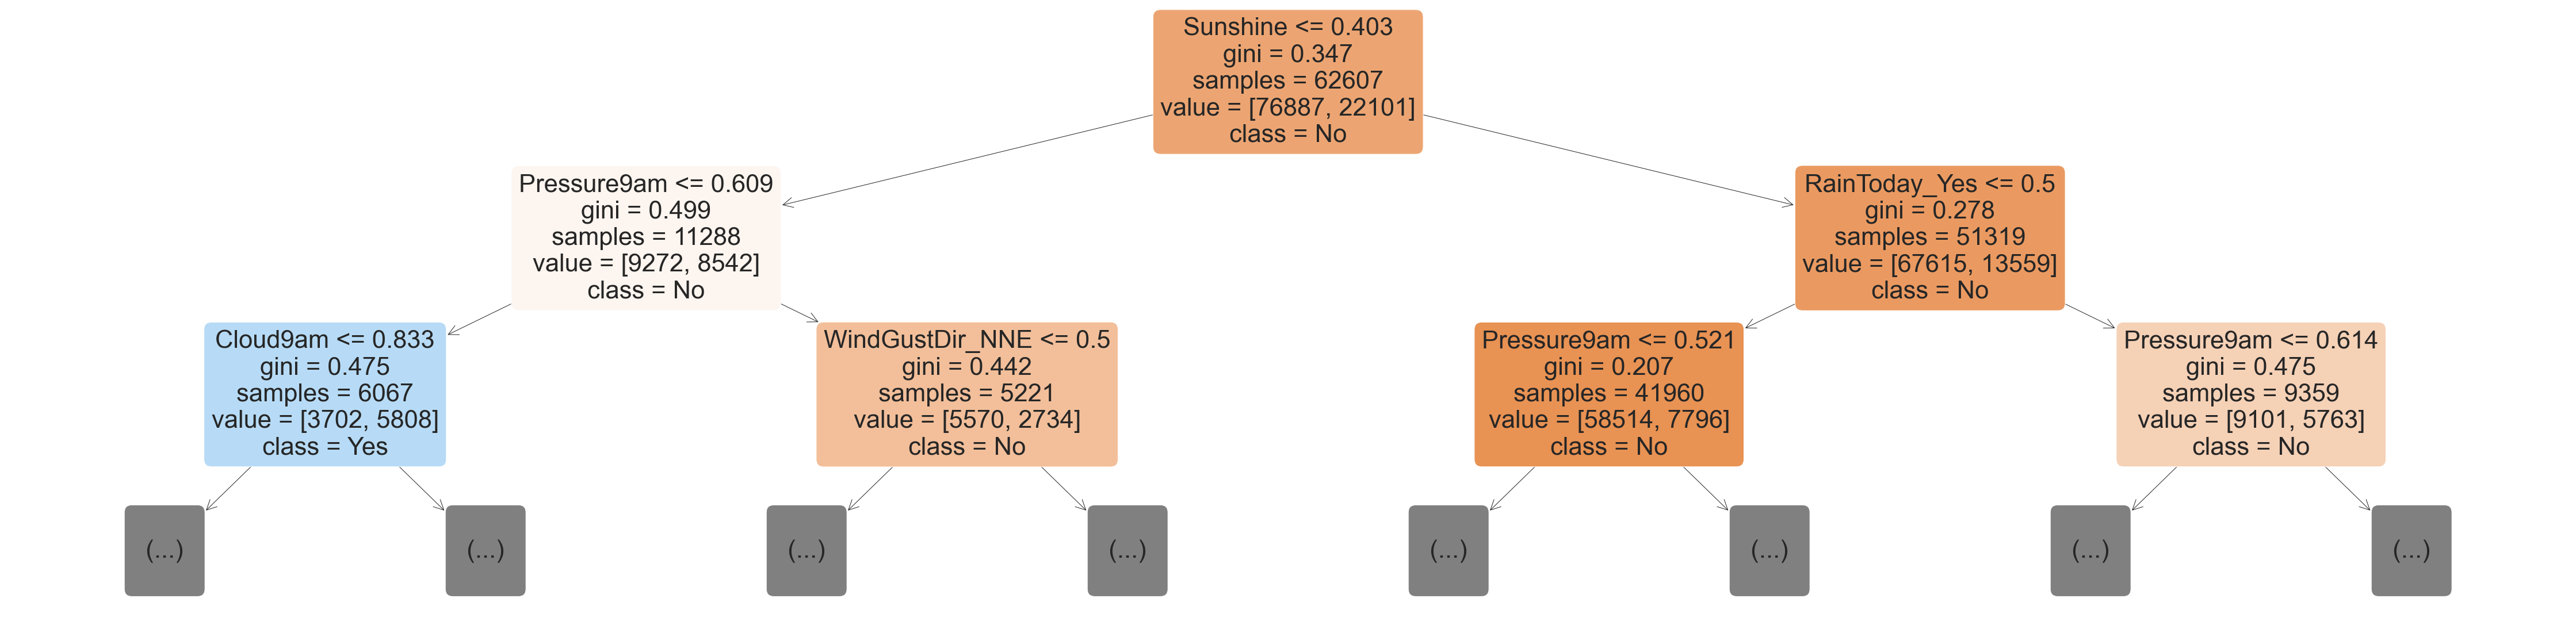

In [46]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[0], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

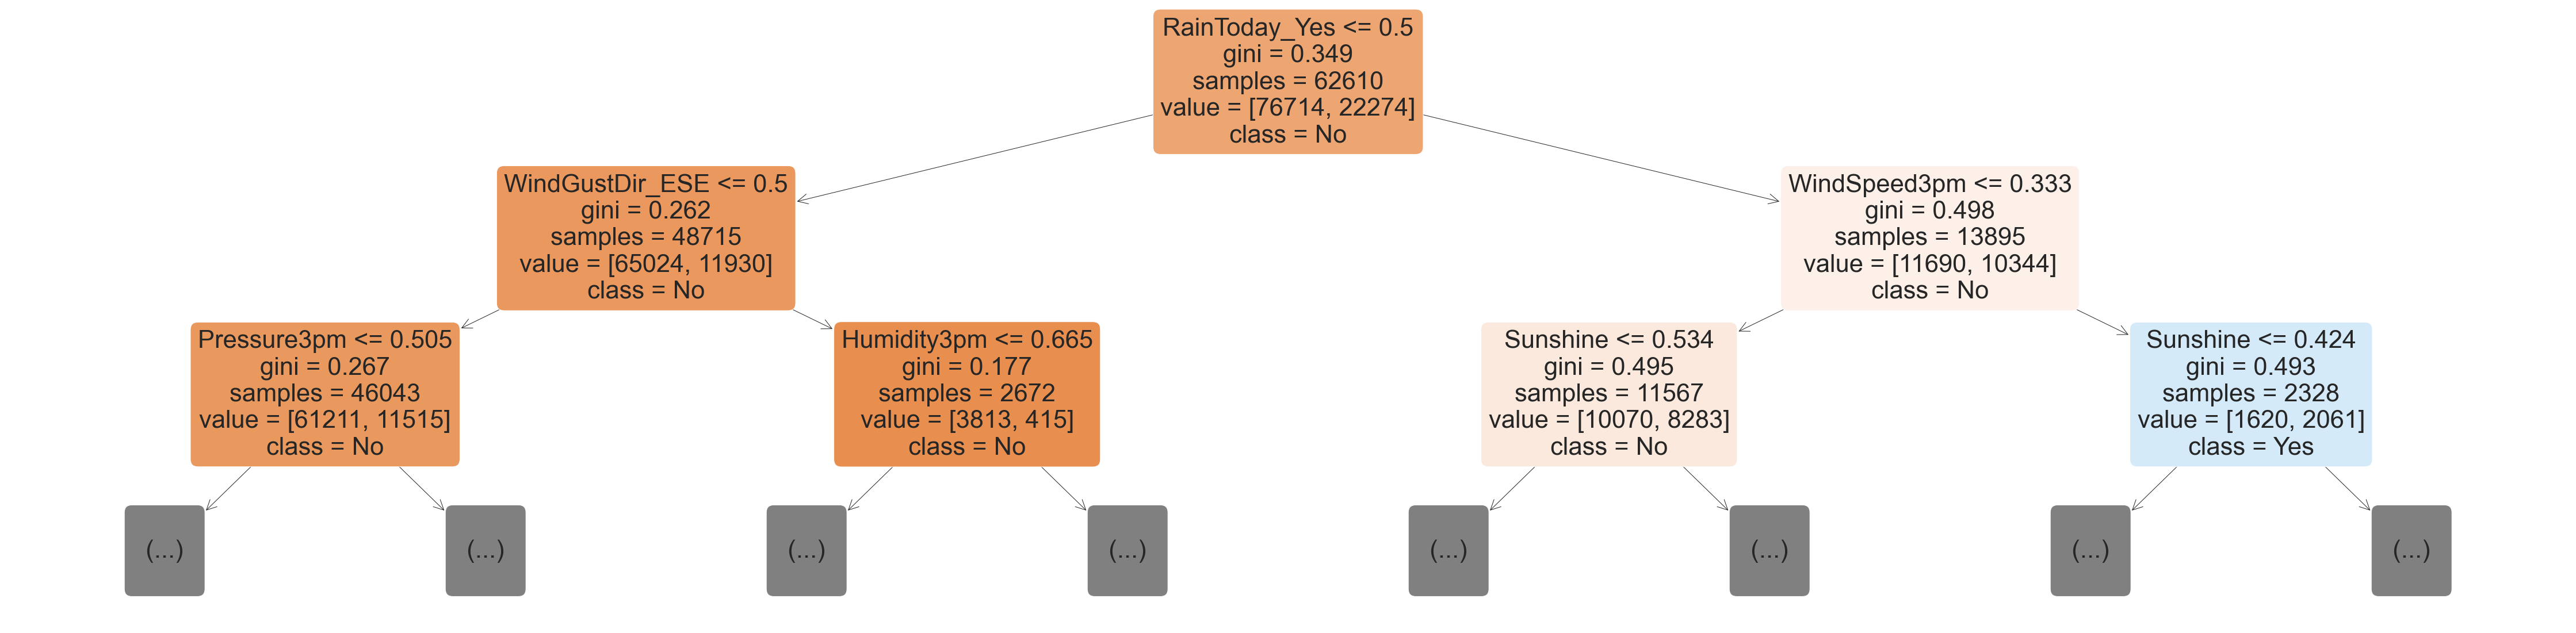

In [47]:
plt.figure(figsize=(80,20))
plot_tree(model.estimators_[20], max_depth=2, feature_names=X_train.columns, filled=True, rounded=True, class_names=model.classes_);

In [48]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
importance_df.head(10)

feature  importance
9     Humidity3pm    0.139904
4        Sunshine    0.053696
11    Pressure3pm    0.052713
8     Humidity9am    0.050051
2        Rainfall    0.048077
10    Pressure9am    0.047944
5   WindGustSpeed    0.047477
15        Temp3pm    0.044379
1         MaxTemp    0.041865
0         MinTemp    0.041199

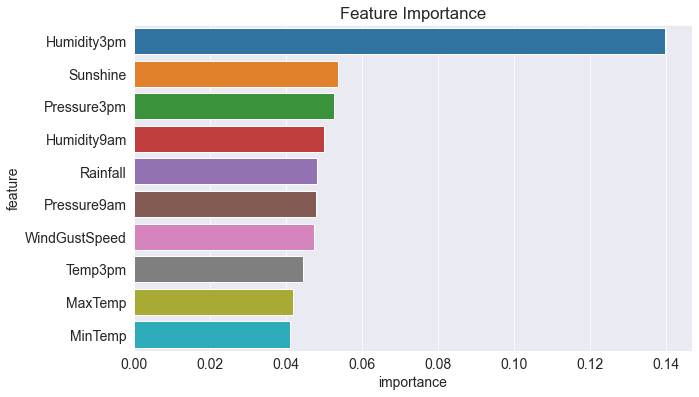

In [49]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

Hyperparameter Tuning with Random Forests

In [51]:
base_model = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_train, train_targets)
base_train_acc = base_model.score(X_train, train_targets)
base_val_acc = base_model.score(X_val, val_targets)
base_accs = base_train_acc, base_val_acc
base_accs

(0.9999494888269285, 0.8566537055307295)

n_estimators
This argument controls the number of decision trees in the random forest. The default value is 100. For larger datasets, it helps to have a greater number of estimators. As a general rule, try to have as few estimators as needed.



In [52]:
#10 estimators
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=10)
model.fit(X_train, train_targets)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

In [53]:
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.986958015112943, 0.8485868492832686)

In [54]:
base_accs


(0.9999494888269285, 0.8566537055307295)

In [55]:
#500 estimator
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=500)
model.fit(X_train, train_targets)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [56]:
model.score(X_train, train_targets)

0.9999797955307714

In [57]:
model.score(X_val, val_targets)

0.8577563693343393

In [ ]:
base_accs

In [58]:
def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(X_train, train_targets)
    return model.score(X_train, train_targets), model.score(X_val, val_targets)

In [59]:
test_params(max_depth=5)

(0.8197862367155615, 0.8240961058557251)

In [60]:
test_params(max_depth=26)

(0.9814826039519942, 0.8572340549010504)

In [61]:
test_params(max_leaf_nodes=2**5)

(0.8314341132258456, 0.833904010214149)

In [62]:
test_params(max_leaf_nodes=2**20)

(0.9999494888269285, 0.8556671116011839)

In [63]:
base_accs 

(0.9999494888269285, 0.8566537055307295)

max_features


In [64]:
test_params(max_features='log2')

(0.9999595910615429, 0.8558992513493123)

In [65]:
test_params(max_features=3)

(0.9999494888269285, 0.8543323080494458)

In [66]:
test_params(max_features=3)

(0.9999494888269285, 0.8543323080494458)

min_samples_split and min_samples_leaf

By default, the decision tree classifier tries to split every node that has 2 or more. You can increase the values of these arguments to change this behavior and reduce overfitting, especially for very large datasets.

In [67]:
test_params(min_samples_split=3, min_samples_leaf=2)


(0.9625005051117307, 0.8565956705936975)

In [68]:
test_params(min_samples_split=100, min_samples_leaf=60)

(0.8495676243585081, 0.8451047530613429)

min_impurity_decrease

This argument is used to control the threshold for splitting nodes. A node will be split if this split induces a decrease of the impurity (Gini index) greater than or equal to this value. It's default value is 0, and you can increase it to reduce overfitting.

In [69]:
test_params(min_impurity_decrease=1e-7)

(0.9996060128500425, 0.8561313910974406)

bootstrap, max_samples
By default, a random forest doesn't use the entire dataset for training each decision tree. Instead it applies a technique called bootstrapping. For each tree, rows from the dataset are picked one by one randomly, with replacement i.e. some rows may not show up at all, while some rows may show up multiple times.


Bootstrapping helps the random forest generalize better, because each decision tree only sees a fraction of th training set, and some rows randomly get higher weightage than others.

In [70]:
test_params(bootstrap=False)

(0.9999797955307714, 0.8567697754047937)

When bootstrapping is enabled, you can also control the number or fraction of rows to be considered for each bootstrap using max_samples. This can further generalize the model.

In [71]:
test_params(max_samples=0.9)

(0.9997676486038711, 0.8565376356566653)